In [4]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from scipy.ndimage import gaussian_filter1d

In [5]:
def read_tfevent_files(log_dir):
    """
    Read all tfevents files from a directory and extract all metrics.
    
    Args:
        log_dir (str): Directory containing tfevents files
        
    Returns:
        dict: Dictionary containing all metric data
    """
    data = {}
    
    # Get all tfevents files in directory
    log_dir = Path(log_dir)
    event_files = list(log_dir.glob('events.out.tfevents.*'))
    
    for file_path in event_files:
        try:
            event_acc = EventAccumulator(str(file_path))
            event_acc.Reload()
            
            # Get all available scalar metrics
            available_tags = event_acc.Tags()['scalars']
            
            # Initialize data structure for new metrics
            for metric in available_tags:
                if metric not in data:
                    data[metric] = {'steps': [], 'values': []}
            
            # Read data for each available metric
            for metric in available_tags:
                events = event_acc.Scalars(metric)
                data[metric]['steps'].extend([event.step for event in events])
                data[metric]['values'].extend([event.value for event in events])
                    
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
            continue
    
    # Sort data by steps for each metric
    for metric in data:
        if len(data[metric]['steps']) > 0:
            steps = np.array(data[metric]['steps'])
            values = np.array(data[metric]['values'])
            sort_idx = np.argsort(steps)
            data[metric]['steps'] = steps[sort_idx]
            data[metric]['values'] = values[sort_idx]
    
    return data

In [6]:
def plot_metric_old(data, metric, ax=None):
    """
    Plot a single metric.
    
    Args:
        data (dict): Dictionary containing all metric data
        metric (str): Name of the metric to plot
        ax (matplotlib.axes, optional): Axes to plot on. If None, creates new figure
        
    Returns:
        matplotlib.figure: Figure object if ax was None
        matplotlib.axes: Axes object with the plot
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))
        created_fig = True
    else:
        created_fig = False
        
    if metric in data and len(data[metric]['steps']) > 0:
        ax.plot(data[metric]['steps'], data[metric]['values'])
        ax.set_title(metric.split('/')[-1].replace('_', ' ').title())
        ax.set_xlabel('Episode')
        ax.set_ylabel('Value')
        ax.grid(True)
    else:
        print(f"No data found for metric: {metric}")
    
    if created_fig:
        plt.tight_layout()
        return fig, ax
    return ax

In [7]:
def plot_metric2(data, metric, ax=None, style='paper', color='#2165E3', 
                window_size=100, show_raw=False, figsize=(10, 6)):
    """
    Plot a single metric with publication-quality styling.
    
    Args:
        data (dict): Dictionary containing metric data
        metric (str): Name of the metric to plot
        ax (matplotlib.axes, optional): Axes to plot on. If None, creates new figure
        style (str): Plot style ('paper' or 'presentation')
        color (str): Main line color (hex or name)
        window_size (int): Window size for moving average smoothing
        show_raw (bool): Whether to show raw data in the background
        figsize (tuple): Figure size if creating new figure
        
    Returns:
        matplotlib.figure: Figure object if ax was None
        matplotlib.axes: Axes object with the plot
    """
   
    # Set the style
    # plt.style.use("seaborn-v0_8")
    plt.style.use('seaborn-paper')
    
    # Create figure if needed
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        created_fig = True
    else:
        created_fig = False
    
    if metric in data and len(data[metric]['steps']) > 0:
        steps = np.array(data[metric]['steps'])
        values = np.array(data[metric]['values'])
        
        # Calculate smoothed values
        smoothed_values = gaussian_filter1d(values, window_size/10)
        
        # Plot raw data if requested
        if show_raw:
            ax.plot(steps, values, alpha=0.2, color=color, linewidth=0.5)
        
        # Plot smoothed line
        ax.plot(steps, smoothed_values, color=color, linewidth=2.5, 
                label=f'Smoothed (window={window_size})')
        
        # Calculate and plot confidence interval
        rolling_std = np.array([np.std(values[max(0, i-window_size):i+1])
                              for i in range(len(values))])
        ax.fill_between(steps, 
                       smoothed_values - rolling_std,
                       smoothed_values + rolling_std,
                       color=color, alpha=0.2)
        
        # Customize appearance
        ax.set_title(metric.split('/')[-1].replace('_', ' ').title(),
                    fontsize=14, pad=20, fontweight='bold')
        ax.set_xlabel('Episode', fontsize=12, labelpad=10)
        ax.set_ylabel('Value', fontsize=12, labelpad=10)
        
        # Grid styling
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_axisbelow(True)  # Put grid behind data
        
        # Spine styling
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)
        
        # Tick styling
        ax.tick_params(axis='both', which='major', labelsize=10, width=1.5, length=6)
        ax.tick_params(axis='both', which='minor', width=1, length=3)
        
        # Scientific notation for large numbers
        ax.ticklabel_format(style='sci', axis='y', scilimits=(-3,4))
        
        # Add minor ticks
        ax.minorticks_on()
        
        # Adjust layout
        plt.tight_layout()
        
    else:
        print(f"No data found for metric: {metric}")
    
    if created_fig:
        return fig, ax
    return ax

In [8]:
def plot_metric(data, metric, ax=None, style='paper', color='#2165E3', 
                window_size=100, show_raw=False, figsize=(10, 6)):
    """
    Plot a single metric with publication-quality styling.
    
    Args:
        data (dict): Dictionary containing metric data
        metric (str): Name of the metric to plot
        ax (matplotlib.axes, optional): Axes to plot on. If None, creates new figure
        style (str): Plot style ('paper' or 'presentation')
        color (str): Main line color (hex or name)
        window_size (int): Window size for moving average smoothing
        show_raw (bool): Whether to show raw data in the background
        figsize (tuple): Figure size if creating new figure
        
    Returns:
        matplotlib.figure: Figure object if ax was None
        matplotlib.axes: Axes object with the plot
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.ndimage import gaussian_filter1d
    
    # Use a clean style
    plt.style.use("seaborn-v0_8")
    
    # Set custom style parameters
    plt.rcParams.update({
        # 'font.family': 'sans-serif',
        # 'font.sans-serif': ['Arial'],
        'font.size': 10,
        'axes.linewidth': 1.5,
        'axes.labelsize': 12,
        'axes.titlesize': 14,
        'xtick.major.width': 1.5,
        'ytick.major.width': 1.5,
        'xtick.minor.width': 1,
        'ytick.minor.width': 1,
    })
    
    # Create figure if needed
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        created_fig = True
    else:
        created_fig = False
    
    if metric in data and len(data[metric]['steps']) > 0:
        steps = np.array(data[metric]['steps'])
        values = np.array(data[metric]['values'])
        
        # Calculate smoothed values
        smoothed_values = gaussian_filter1d(values, window_size/10)
        
        # Plot raw data if requested
        if show_raw:
            ax.plot(steps, values, alpha=0.2, color=color, linewidth=0.5)
        
        # Plot smoothed line
        ax.plot(steps, smoothed_values, color=color, linewidth=2.5, 
                label=f'Smoothed (window={window_size})')
        
        # Calculate and plot confidence interval
        rolling_std = np.array([np.std(values[max(0, i-window_size):i+1])
                              for i in range(len(values))])
        ax.fill_between(steps, 
                       smoothed_values - rolling_std,
                       smoothed_values + rolling_std,
                       color=color, alpha=0.2)
        
        # Customize appearance
        ax.set_title(metric.split('/')[-1].replace('_', ' ').title(),
                    fontsize=14, pad=20, fontweight='bold')
        ax.set_xlabel('Episode', fontsize=12, labelpad=10)
        ax.set_ylabel('Value', fontsize=12, labelpad=10)
        
        # Grid styling
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_axisbelow(True)  # Put grid behind data
        
        # Spine styling
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)
        
        # Tick styling
        ax.tick_params(axis='both', which='major', labelsize=10, width=1.5, length=6)
        ax.tick_params(axis='both', which='minor', width=1, length=3)
        
        # Scientific notation for large numbers
        ax.ticklabel_format(style='sci', axis='y', scilimits=(-3,4))
        
        # Add minor ticks
        ax.minorticks_on()
        
        # Adjust layout
        plt.tight_layout()
        
    else:
        print(f"No data found for metric: {metric}")
    
    if created_fig:
        return fig, ax
    return ax

In [9]:
def plot_metrics(data, metrics_to_plot, figsize=(15, 5)):
    """
    Plot multiple metrics in separate subplots.
    
    Args:
        data (dict): Dictionary containing all metric data
        metrics_to_plot (list): List of metric names to plot
        figsize (tuple): Figure size (width, height)
        
    Returns:
        matplotlib.figure: Figure object
    """
    n_metrics = len(metrics_to_plot)
    fig, axes = plt.subplots(1, n_metrics, figsize=figsize)
    
    # If there's only one metric, axes won't be an array
    if n_metrics == 1:
        axes = [axes]
    
    for ax, metric in zip(axes, metrics_to_plot):
        plot_metric(data, metric, ax)
    
    plt.tight_layout()
    return fig

In [10]:
# Example usage
# Read all available data
data = read_tfevent_files('logs/DQN_0')

# Plot all available metrics
print("Available metrics:", list(data.keys()))

Available metrics: ['episode/lines_cleared', 'episode/pieces_placed', 'episode/score', 'rollout/ep_len_mean', 'rollout/ep_rew_mean', 'rollout/exploration_rate', 'time/fps', 'train/learning_rate', 'train/loss', 'eval/mean_ep_length', 'eval/mean_reward']


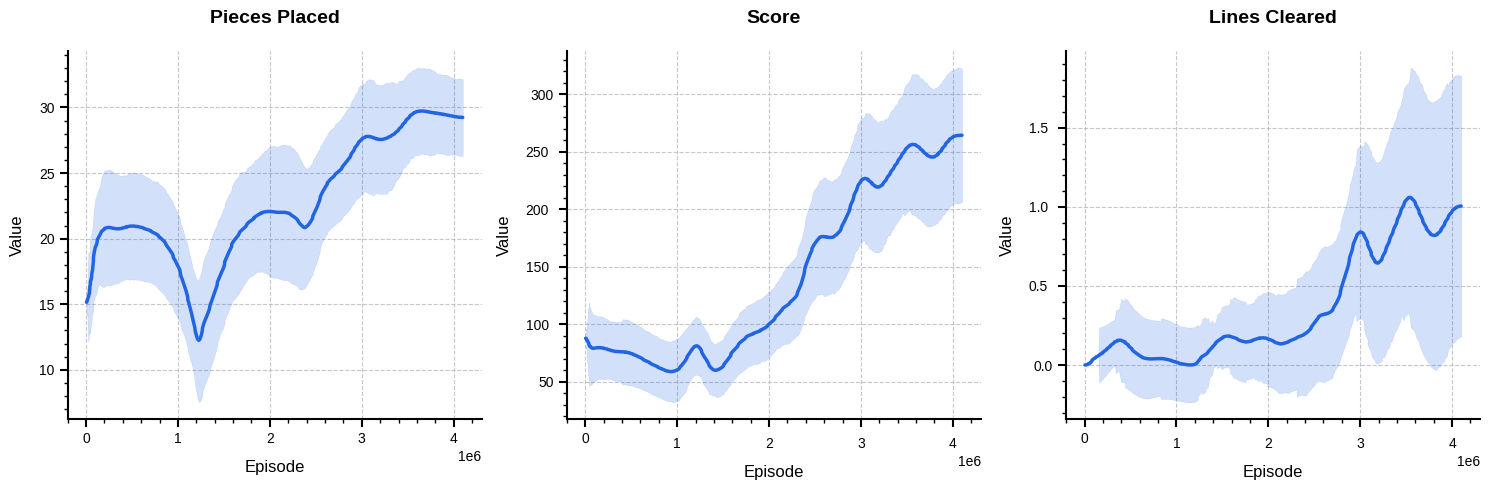

In [11]:
metrics_of_interest = [
    'episode/pieces_placed',
    'episode/score',
    'episode/lines_cleared'
]

fig = plot_metrics(data, metrics_of_interest)
plt.show()

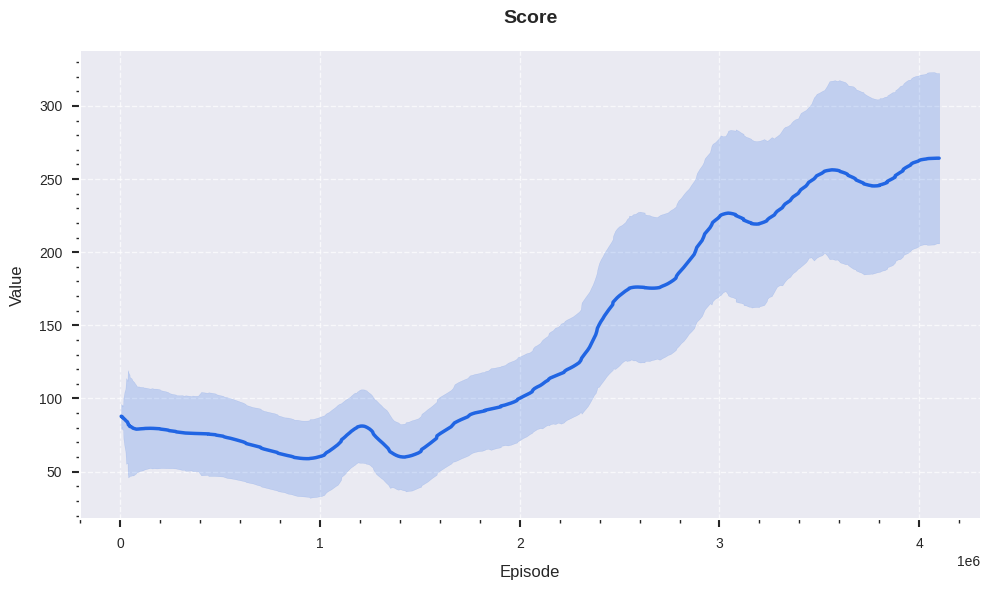

In [12]:
# Plot a single metric
fig, ax = plot_metric(data, 'episode/score')
plt.show()

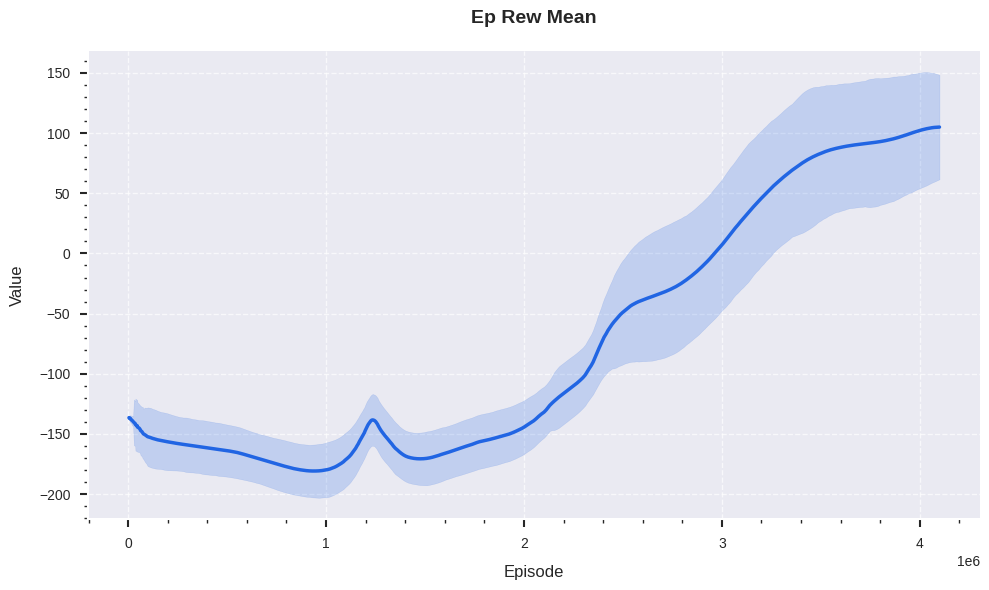

In [13]:
fig, ax = plot_metric(data, 'rollout/ep_rew_mean')
plt.show()

In [14]:
pd.DataFrame(sorted(data.keys()))

,0
0,episode/lines_cleared
1,episode/pieces_placed
2,episode/score
3,eval/mean_ep_length
4,eval/mean_reward
5,rollout/ep_len_mean
6,rollout/ep_rew_mean
7,rollout/exploration_rate
8,time/fps
9,train/learning_rate


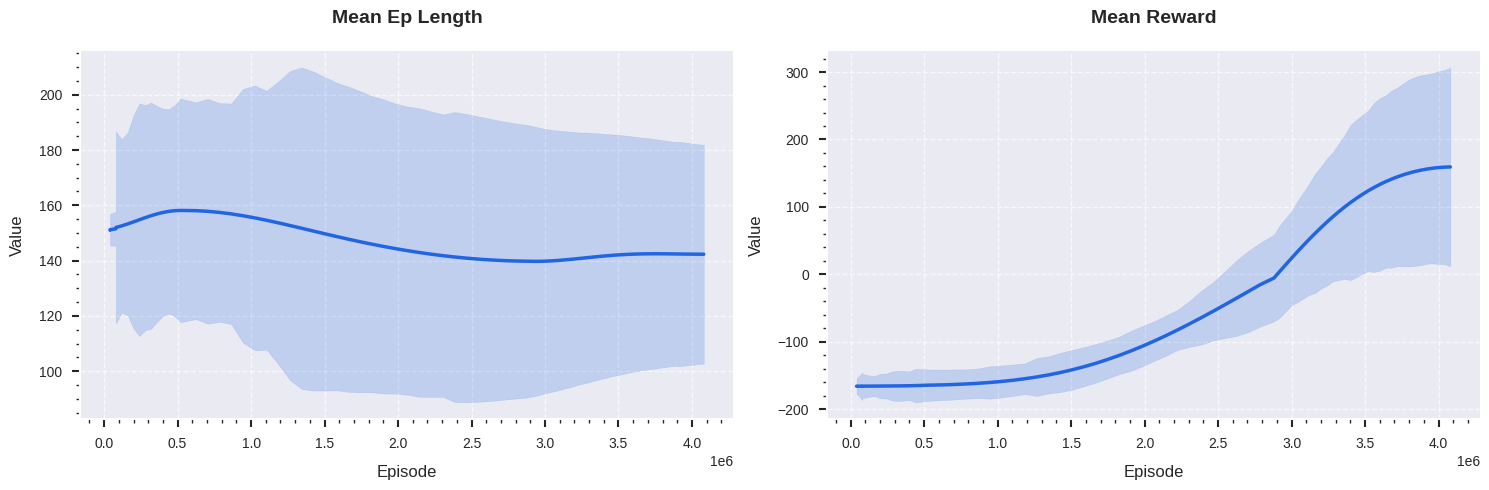

In [15]:
fig = plot_metrics(data, ["eval/mean_ep_length", "eval/mean_reward"])
plt.show()